# Stock Prediction with RNN  
RNN을 이용한 간단한 주식 예측 모델을 학습해보겠습니다.

In [1]:
## library import
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)
print(keras.__version__)

2.0.0-beta1
2.2.4-tf


## Hyper Parameters

In [2]:
# train Parameters
seq_length = 7
data_dim = 5
hidden_size = 10
output_dim = 1
learning_rate = 0.001
training_epochs = 500
batch_size = 25

## Preparing Data

### MinMax Scaling

In [3]:
def MinMaxScaler(data):
    ''' Min Max Normalization
    Parameters
    ----------
    data : numpy.ndarray
        input data to be normalized
        shape: [Batch size, dimension]
    Returns
    ----------
    data : numpy.ndarry
        normalized data
        shape: [Batch size, dimension]
    References
    ----------
    .. [1] http://sebastianraschka.com/Articles/2014_about_feature_scaling.html
    '''
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # noise term prevents the zero division
    return numerator / (denominator + 1e-7)

### Loading Data File

In [8]:
# Open, High, Low, Volume, Close
xy = np.loadtxt('/content/gdrive/My Drive/TensorFlow_Training_13th/data/data-02-stock_daily.csv', delimiter=',')
#xy = np.loadtxt('./data/data-02-stock_daily.csv', delimiter=',')
xy = xy[::-1]  # reverse order (chronically ordered)
xy = MinMaxScaler(xy).astype(np.float32)
x = xy
y = xy[:, [-1]]  # Close as label

### Making a Dataset

In [9]:
# build a dataset
dataX = []
dataY = []
for i in range(0, len(y) - seq_length):
    _x = x[i:i + seq_length]
    _y = y[i + seq_length]  # Next close price
    print(_x, "->", _y)
    dataX.append(_x)
    dataY.append(_y)

[[2.1375105e-01 2.0817982e-01 1.9179183e-01 4.6607511e-04 1.9209240e-01]
 [1.9393504e-01 2.0364192e-01 2.0866457e-01 2.9846733e-03 1.9655156e-01]
 [2.1051645e-01 2.0528941e-01 2.0355874e-01 2.5992651e-04 1.8774973e-01]
 [1.8667877e-01 2.0948057e-01 2.0878184e-01 0.0000000e+00 2.1744815e-01]
 [3.0697387e-01 3.1463414e-01 2.1899366e-01 1.2476472e-02 2.1698189e-01]
 [2.1914211e-01 2.6390722e-01 2.2468640e-01 4.5632339e-01 2.2496748e-01]
 [2.3312993e-01 2.3641916e-01 1.6268273e-01 5.7017118e-01 1.4744274e-01]] -> [0.13289961]
[[1.9393504e-01 2.0364192e-01 2.0866457e-01 2.9846733e-03 1.9655156e-01]
 [2.1051645e-01 2.0528941e-01 2.0355874e-01 2.5992651e-04 1.8774973e-01]
 [1.8667877e-01 2.0948057e-01 2.0878184e-01 0.0000000e+00 2.1744815e-01]
 [3.0697387e-01 3.1463414e-01 2.1899366e-01 1.2476472e-02 2.1698189e-01]
 [2.1914211e-01 2.6390722e-01 2.2468640e-01 4.5632339e-01 2.2496748e-01]
 [2.3312993e-01 2.3641916e-01 1.6268273e-01 5.7017118e-01 1.4744274e-01]
 [1.3431200e-01 1.5175878e-01 1.16

 [0.68428504 0.7038197  0.7098487  0.16614681 0.69567305]] -> [0.7029883]
[[0.6290045  0.64248526 0.65274584 0.12979296 0.6539089 ]
 [0.6442452  0.64173377 0.65286314 0.17037734 0.63610166]
 [0.63063633 0.652197   0.64053875 0.16836067 0.66612047]
 [0.6533664  0.6609551  0.66656667 0.13959846 0.6691806 ]
 [0.6625168  0.68537885 0.68763566 0.15226315 0.6865216 ]
 [0.68428504 0.7038197  0.7098487  0.16614681 0.69567305]
 [0.6902008  0.6920557  0.7026303  0.13477637 0.7029883 ]] -> [0.67713714]
[[0.6442452  0.64173377 0.65286314 0.17037734 0.63610166]
 [0.63063633 0.652197   0.64053875 0.16836067 0.66612047]
 [0.6533664  0.6609551  0.66656667 0.13959846 0.6691806 ]
 [0.6625168  0.68537885 0.68763566 0.15226315 0.6865216 ]
 [0.68428504 0.7038197  0.7098487  0.16614681 0.69567305]
 [0.6902008  0.6920557  0.7026303  0.13477637 0.7029883 ]
 [0.6864125  0.69003254 0.6803876  0.18480775 0.67713714]] -> [0.6871337]
[[0.63063633 0.652197   0.64053875 0.16836067 0.66612047]
 [0.6533664  0.6609551 

In [10]:
# train/test split
train_size = int(len(dataY) * 0.7 + 18)
test_size = len(dataY) - train_size
trainX, testX = np.array(dataX[0:train_size]), np.array(
    dataX[train_size:len(dataX)])
trainY, testY = np.array(dataY[0:train_size]), np.array(
    dataY[train_size:len(dataY)])
print(trainX.shape, trainY.shape)
print(testX.shape, testX.shape)

(525, 7, 5) (525, 1)
(200, 7, 5) (200, 7, 5)


In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices((trainX, trainY)).shuffle(
                buffer_size=1000).prefetch(buffer_size=batch_size).batch(batch_size).repeat()
test_dataset = tf.data.Dataset.from_tensor_slices((testX, testY)).prefetch(
                buffer_size=batch_size).batch(batch_size)

## Model Function

In [14]:
def create_model():
    model = keras.Sequential()
    model.add(keras.layers.LSTM(units=hidden_size, return_sequences=True,
                                     input_shape=(trainX.shape[1],trainX.shape[2])))
    model.add(keras.layers.LSTM(units=hidden_size))
    model.add(keras.layers.Dense(units=output_dim))
    return model

In [15]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 10)             640       
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                840       
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 1,491
Trainable params: 1,491
Non-trainable params: 0
_________________________________________________________________


## Model Compile

In [20]:
def rmse_opt(learning_rate):
    return keras.optimizers.RMSprop(learning_rate)

model.compile(optimizer=rmse_opt(learning_rate),
              loss='mse',
              metrics=[keras.metrics.RootMeanSquaredError()])             

## Training

In [21]:
model.fit(train_dataset, epochs=training_epochs,
          steps_per_epoch=trainX.shape[0]//batch_size,
          validation_data=test_dataset,
          validation_steps=testX.shape[0]//batch_size)

Epoch 1/500
21/21 [==============================] - 3s 136ms/step - loss: 0.0408 - root_mean_squared_error: 0.2021 - val_loss: 0.0625 - val_root_mean_squared_error: 0.2500
Epoch 2/500
21/21 [==============================] - 0s 7ms/step - loss: 0.0078 - root_mean_squared_error: 0.0881 - val_loss: 0.0197 - val_root_mean_squared_error: 0.1403
Epoch 3/500
21/21 [==============================] - 0s 7ms/step - loss: 0.0040 - root_mean_squared_error: 0.0630 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0885
Epoch 4/500
21/21 [==============================] - 0s 6ms/step - loss: 0.0035 - root_mean_squared_error: 0.0591 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0896
Epoch 5/500
21/21 [==============================] - 0s 6ms/step - loss: 0.0034 - root_mean_squared_error: 0.0583 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0842
Epoch 6/500
21/21 [==============================] - 0s 7ms/step - loss: 0.0032 - root_mean_squared_error: 0.0569 - val_loss: 0.0050 - val_root

Epoch 49/500
21/21 [==============================] - 0s 7ms/step - loss: 0.0019 - root_mean_squared_error: 0.0440 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0394
Epoch 50/500
21/21 [==============================] - 0s 6ms/step - loss: 0.0018 - root_mean_squared_error: 0.0424 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0621
Epoch 51/500
21/21 [==============================] - 0s 7ms/step - loss: 0.0018 - root_mean_squared_error: 0.0425 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0576
Epoch 52/500
21/21 [==============================] - 0s 6ms/step - loss: 0.0018 - root_mean_squared_error: 0.0427 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0413
Epoch 53/500
21/21 [==============================] - 0s 6ms/step - loss: 0.0018 - root_mean_squared_error: 0.0423 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0421
Epoch 54/500
21/21 [==============================] - 0s 6ms/step - loss: 0.0018 - root_mean_squared_error: 0.0423 - val_loss: 0.0038 - val_

21/21 [==============================] - 0s 7ms/step - loss: 0.0011 - root_mean_squared_error: 0.0337 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0408
Epoch 97/500
21/21 [==============================] - 0s 7ms/step - loss: 0.0012 - root_mean_squared_error: 0.0342 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0663
Epoch 98/500
21/21 [==============================] - 0s 6ms/step - loss: 0.0012 - root_mean_squared_error: 0.0344 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0657
Epoch 99/500
21/21 [==============================] - 0s 6ms/step - loss: 0.0013 - root_mean_squared_error: 0.0355 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0479
Epoch 100/500
21/21 [==============================] - 0s 7ms/step - loss: 0.0012 - root_mean_squared_error: 0.0349 - val_loss: 9.7690e-04 - val_root_mean_squared_error: 0.0313
Epoch 101/500
21/21 [==============================] - 0s 6ms/step - loss: 0.0011 - root_mean_squared_error: 0.0337 - val_loss: 0.0013 - val_root_me

21/21 [==============================] - 0s 6ms/step - loss: 0.0010 - root_mean_squared_error: 0.0324 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0410
Epoch 144/500
21/21 [==============================] - 0s 7ms/step - loss: 0.0010 - root_mean_squared_error: 0.0317 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0350
Epoch 145/500
21/21 [==============================] - 0s 6ms/step - loss: 0.0010 - root_mean_squared_error: 0.0319 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0386
Epoch 146/500
21/21 [==============================] - 0s 6ms/step - loss: 9.8210e-04 - root_mean_squared_error: 0.0313 - val_loss: 9.2030e-04 - val_root_mean_squared_error: 0.0303
Epoch 147/500
21/21 [==============================] - 0s 7ms/step - loss: 9.5677e-04 - root_mean_squared_error: 0.0309 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0360
Epoch 148/500
21/21 [==============================] - 0s 7ms/step - loss: 0.0010 - root_mean_squared_error: 0.0319 - val_loss: 9.6241e-0

21/21 [==============================] - 0s 7ms/step - loss: 9.3629e-04 - root_mean_squared_error: 0.0306 - val_loss: 7.5719e-04 - val_root_mean_squared_error: 0.0275
Epoch 190/500
21/21 [==============================] - 0s 6ms/step - loss: 0.0010 - root_mean_squared_error: 0.0317 - val_loss: 9.6750e-04 - val_root_mean_squared_error: 0.0311
Epoch 191/500
21/21 [==============================] - 0s 6ms/step - loss: 9.0836e-04 - root_mean_squared_error: 0.0301 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0470
Epoch 192/500
21/21 [==============================] - 0s 7ms/step - loss: 9.2332e-04 - root_mean_squared_error: 0.0304 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0429
Epoch 193/500
21/21 [==============================] - 0s 7ms/step - loss: 9.8076e-04 - root_mean_squared_error: 0.0313 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0367
Epoch 194/500
21/21 [==============================] - 0s 6ms/step - loss: 9.3277e-04 - root_mean_squared_error: 0.0305 - val

Epoch 235/500
21/21 [==============================] - 0s 6ms/step - loss: 9.3430e-04 - root_mean_squared_error: 0.0306 - val_loss: 8.7183e-04 - val_root_mean_squared_error: 0.0295
Epoch 236/500
21/21 [==============================] - 0s 6ms/step - loss: 8.6473e-04 - root_mean_squared_error: 0.0294 - val_loss: 8.4060e-04 - val_root_mean_squared_error: 0.0290
Epoch 237/500
21/21 [==============================] - 0s 6ms/step - loss: 8.7852e-04 - root_mean_squared_error: 0.0296 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0551
Epoch 238/500
21/21 [==============================] - 0s 6ms/step - loss: 9.2500e-04 - root_mean_squared_error: 0.0304 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0327
Epoch 239/500
21/21 [==============================] - 0s 6ms/step - loss: 8.8862e-04 - root_mean_squared_error: 0.0298 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0501
Epoch 240/500
21/21 [==============================] - 0s 8ms/step - loss: 9.0280e-04 - root_mean_squared_e

Epoch 281/500
21/21 [==============================] - 0s 8ms/step - loss: 8.5315e-04 - root_mean_squared_error: 0.0292 - val_loss: 8.1859e-04 - val_root_mean_squared_error: 0.0286
Epoch 282/500
21/21 [==============================] - 0s 8ms/step - loss: 8.8062e-04 - root_mean_squared_error: 0.0297 - val_loss: 8.0014e-04 - val_root_mean_squared_error: 0.0283
Epoch 283/500
21/21 [==============================] - 0s 7ms/step - loss: 8.3171e-04 - root_mean_squared_error: 0.0288 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0385
Epoch 284/500
21/21 [==============================] - 0s 8ms/step - loss: 8.6726e-04 - root_mean_squared_error: 0.0294 - val_loss: 9.8180e-04 - val_root_mean_squared_error: 0.0313
Epoch 285/500
21/21 [==============================] - 0s 8ms/step - loss: 8.5161e-04 - root_mean_squared_error: 0.0292 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0365
Epoch 286/500
21/21 [==============================] - 0s 8ms/step - loss: 8.4747e-04 - root_mean_squar

Epoch 327/500
21/21 [==============================] - 0s 6ms/step - loss: 8.0144e-04 - root_mean_squared_error: 0.0283 - val_loss: 6.8808e-04 - val_root_mean_squared_error: 0.0262
Epoch 328/500
21/21 [==============================] - 0s 8ms/step - loss: 8.4778e-04 - root_mean_squared_error: 0.0291 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0337
Epoch 329/500
21/21 [==============================] - 0s 7ms/step - loss: 8.3435e-04 - root_mean_squared_error: 0.0289 - val_loss: 9.3582e-04 - val_root_mean_squared_error: 0.0306
Epoch 330/500
21/21 [==============================] - 0s 6ms/step - loss: 8.3245e-04 - root_mean_squared_error: 0.0289 - val_loss: 7.2221e-04 - val_root_mean_squared_error: 0.0269
Epoch 331/500
21/21 [==============================] - 0s 7ms/step - loss: 8.4911e-04 - root_mean_squared_error: 0.0291 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0323
Epoch 332/500
21/21 [==============================] - 0s 6ms/step - loss: 8.1102e-04 - root_mean_squar

Epoch 373/500
21/21 [==============================] - 0s 6ms/step - loss: 8.2259e-04 - root_mean_squared_error: 0.0287 - val_loss: 7.6024e-04 - val_root_mean_squared_error: 0.0276
Epoch 374/500
21/21 [==============================] - 0s 7ms/step - loss: 7.8486e-04 - root_mean_squared_error: 0.0280 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0322
Epoch 375/500
21/21 [==============================] - 0s 6ms/step - loss: 8.3754e-04 - root_mean_squared_error: 0.0289 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0317
Epoch 376/500
21/21 [==============================] - 0s 6ms/step - loss: 8.2310e-04 - root_mean_squared_error: 0.0287 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0334
Epoch 377/500
21/21 [==============================] - 0s 7ms/step - loss: 8.0804e-04 - root_mean_squared_error: 0.0284 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0465
Epoch 378/500
21/21 [==============================] - 0s 6ms/step - loss: 7.9905e-04 - root_mean_squared_error

Epoch 419/500
21/21 [==============================] - 0s 6ms/step - loss: 7.9537e-04 - root_mean_squared_error: 0.0282 - val_loss: 8.3343e-04 - val_root_mean_squared_error: 0.0289
Epoch 420/500
21/21 [==============================] - 0s 6ms/step - loss: 7.8478e-04 - root_mean_squared_error: 0.0280 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0339
Epoch 421/500
21/21 [==============================] - 0s 7ms/step - loss: 8.2636e-04 - root_mean_squared_error: 0.0287 - val_loss: 9.7584e-04 - val_root_mean_squared_error: 0.0312
Epoch 422/500
21/21 [==============================] - 0s 7ms/step - loss: 7.9378e-04 - root_mean_squared_error: 0.0282 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0366
Epoch 423/500
21/21 [==============================] - 0s 7ms/step - loss: 7.9580e-04 - root_mean_squared_error: 0.0282 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0351
Epoch 424/500
21/21 [==============================] - 0s 6ms/step - loss: 7.9946e-04 - root_mean_squared_e

Epoch 465/500
21/21 [==============================] - 0s 6ms/step - loss: 7.6315e-04 - root_mean_squared_error: 0.0276 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0328
Epoch 466/500
21/21 [==============================] - 0s 6ms/step - loss: 7.8031e-04 - root_mean_squared_error: 0.0279 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0354
Epoch 467/500
21/21 [==============================] - 0s 6ms/step - loss: 7.6074e-04 - root_mean_squared_error: 0.0276 - val_loss: 7.8627e-04 - val_root_mean_squared_error: 0.0280
Epoch 468/500
21/21 [==============================] - 0s 6ms/step - loss: 8.1307e-04 - root_mean_squared_error: 0.0285 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0385
Epoch 469/500
21/21 [==============================] - 0s 7ms/step - loss: 7.6650e-04 - root_mean_squared_error: 0.0277 - val_loss: 9.0182e-04 - val_root_mean_squared_error: 0.0300
Epoch 470/500
21/21 [==============================] - 0s 7ms/step - loss: 7.8879e-04 - root_mean_squared_e

## Checking the Test Result

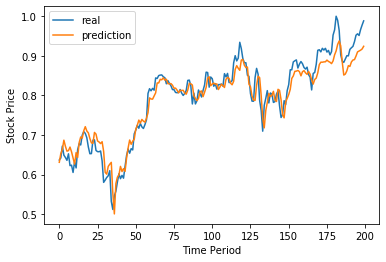

In [22]:
prediction = model.predict(test_dataset)

plt.plot(testY)
plt.plot(prediction)
plt.xlabel("Time Period")
plt.ylabel("Stock Price")
plt.legend(['real', 'prediction'])
plt.show()